# 线性回归
主要内容包括：

1. 线性回归的基本要素
2. 线性回归模型从零开始的实现
3. 线性回归模型使用pytorch的简洁实现

## 线性回归的基本要素

### 模型
为了简单起见，这里我们假设价格只取决于房屋状况的两个因素，即面积（平方米）和房龄（年）。接下来我们希望探索价格与这两个因素的具体关系。线性回归假设输出与各个输入之间是线性关系:


$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



### 数据集
我们通常收集一系列的真实数据，例如多栋房屋的真实售出价格和它们对应的面积和房龄。我们希望在这个数据上面寻找模型参数来使模型的预测价格与真实价格的误差最小。在机器学习术语里，该数据集被称为训练数据集（training data set）或训练集（training set），一栋房屋被称为一个样本（sample），其真实售出价格叫作标签（label），用来预测标签的两个因素叫作特征（feature）。特征用来表征样本的特点。
### 损失函数
在模型训练中，我们需要衡量价格预测值与真实值之间的误差。通常我们会选取一个非负数作为误差，且数值越小表示误差越小。一个常用的选择是平方函数（均方误差））。 它在评估索引为 $i$ 的样本误差的表达式为


$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,
$$

（训练时每次取小批量，则首先对单个样本计算，再求和平均）

$$
L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.
$$


### 优化函数 - 随机梯度下降
当模型和损失函数形式较为简单时，上面的误差最小化问题的解可以直接用公式表达出来。这类解叫作解析解（analytical solution）。本节使用的线性回归和平方误差刚好属于这个范畴。然而，大多数深度学习模型并没有解析解，只能通过优化算法有限次迭代模型参数来尽可能降低损失函数的值。这类解叫作数值解（numerical solution）。

在求数值解的优化算法中，小批量随机梯度下降（mini-batch stochastic gradient descent）在深度学习中被广泛使用。它的算法很简单：先选取一组模型参数的初始值，如随机选取；接下来对参数进行多次迭代，使每次迭代都可能降低损失函数的值。在每次迭代中，先随机均匀采样一个由固定数目训练数据样本所组成的小批量（mini-batch）$\mathcal{B}$，然后求小批量中数据样本的平均损失有关模型参数的导数（梯度），最后用此结果与预先设定的一个正数的乘积作为模型参数在本次迭代的减小量。   

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$
  
学习率: $\eta$代表在每次优化中，能够学习的步长的大小    
批量大小: $\mathcal{B}$是小批量计算中的批量大小batch size   

总结一下，优化函数的有以下两个步骤：

- (i)初始化模型参数，一般来说使用随机初始化；
- (ii)我们在数据上迭代多次，通过在负梯度方向移动参数来更新每个参数。

## 矢量计算
（时间测试，比较两种方法的时间，从而比较性能）

在模型训练或预测时，我们常常会同时处理多个数据样本并用到矢量计算。在介绍线性回归的矢量计算表达式之前，让我们先考虑对两个向量相加的两种方法。


1. 向量相加的一种方法是，将这两个向量按元素逐一做标量加法。
2. 向量相加的另一种方法是，将这两个向量直接做矢量加法。

In [5]:
import torch
import time

# init variable a, b as 1000 dimension vector
n = 1000
a = torch.ones(n)
b = torch.ones(n)


In [3]:
# define a timer class to record time
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # start the timer
        self.start_time = time.time()

    def stop(self):
        # stop the timer and record time into a list
        self.times.append(time.time() - self.start_time)
        return self.times[-1]

    def avg(self):
        # calculate the average and return
        return sum(self.times)/len(self.times)

    def sum(self):
        # return the sum of recorded time
        return sum(self.times)

现在我们可以来测试了。首先将两个向量使用for循环按元素逐一做标量加法。

In [4]:
timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]
'%.5f sec' % timer.stop()

'0.73000 sec'

另外是使用torch来将两个向量直接做矢量加法：

In [5]:
timer.start()
d = a + b
'%.5f sec' % timer.stop()

'0.00000 sec'

结果很明显,后者比前者运算速度更快。因此，我们应该尽可能采用矢量计算，以提升计算效率。

## 线性回归模型从零开始的实现



In [7]:
# import packages and modules
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.4.0+cpu


### 生成数据集
使用线性模型来生成数据集，生成一个1000个样本的数据集，下面是用来生成数据的线性关系：

$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



In [8]:
# set input feature number 
#设置输入特征的数量；在这里用了两个特征，所以设为2
num_inputs = 2
# set example number
num_examples = 1000

# set true weight and bias in order to generate corresponded label
#设置真实的权重和偏差，这两个参数也是要训练学习的两个参数，在这里设置是为了通过特诊来生成对应的标签
true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
#实际上不可能直接符合这个偏差，因此又再加上了一个偏差，是呈正态分布的偏差，随机生成的
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [9]:
print(features[:2])

tensor([[ 0.0047, -0.1640],
        [ 0.5338,  0.6599]])


In [10]:
print(features[:5,1])

tensor([-0.1640,  0.6599,  2.7937,  0.1683,  0.9440])


### 使用图像来展示生成的数据

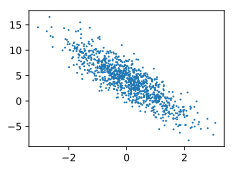

In [11]:
def use_svq_display():
    #display in vector graph
    #s设置图片展示的类型   展示为向量图
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5,2.5)):
    #set the size of figure 
    #设置向量图展示时的大小，默认为3.5*2.5
    use_svq_display()
    plt.rcParams['figure.figsize']=figsize
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

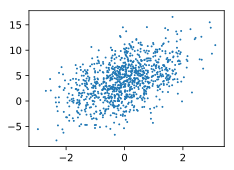

In [12]:
set_figsize()
plt.scatter(features[:, 0].numpy(), labels.numpy(), 1);

### 读取数据集

In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # random read 10 samples 打乱数据，而不是按照顺序排列的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # the last time may be not enough for a whole batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [16]:
batch_size = 10
#小批次取数据
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    #X:数据  y：标签
    break

tensor([[ 1.1856, -0.3990],
        [-0.4267,  0.5455],
        [ 0.5518,  0.7512],
        [ 1.4582,  0.8925],
        [ 0.3566,  0.0521],
        [-1.6205, -1.2835],
        [-0.2115,  0.9821],
        [ 1.7539,  0.4733],
        [-1.4236,  0.4318],
        [-0.7940,  0.2479]]) 
 tensor([ 7.9231,  1.4872,  2.7344,  4.0649,  4.7346,  5.3277,  0.4302,  6.1148,
        -0.1093,  1.7655])


### 初始化模型参数

In [17]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)
#附加梯度，才能通过链式法则，反向传播求梯度

tensor([0.], requires_grad=True)

### 定义模型
定义用来训练参数的训练模型：

$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



In [18]:
def linreg(X, w, b):
    return torch.mm(X, w) + b
#输出预测值

### 定义损失函数
我们使用的是均方误差损失函数：
$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,
$$


In [29]:
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2
#view函数用来将tensor y的shape和y_hat进行统一

torch.Tensoe.view(python method, in torch.Tensor)

作用: 将输入的torch.Tensor改变形状(size)并返回.返回的Tensor与输入的Tensor必须有相同的元素,相同的元素数目,但形状可以不一样

即,view起到的作用是reshape,view的参数的是改变后的shape.

tensor_1.view_as(tensor_2):将tensor_1的形状改成与tensor_2一样
————————————————
版权声明：本文为CSDN博主「wzg2016」的原创文章，遵循 CC 4.0 BY-SA 版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/Strive_For_Future/article/details/83240116

y_hat 是列向量，y是行向量，它俩得统一
view(-1,1) 把y由一个行向量转成了列向量，view(-1)的话相当于啥也没干（当传入的是一个1维向量时相当于没用），也不是全部都没用。

例如：
比如你给一个 长度为6的向量，view(-1,2) 它就会给你转成 3*2的矩阵。3是通过-1自己算出来的
他有个参数是-2然后就肯定会变成一个两列的向量，然后因为总长度是6所以他肯定是3行。
也就是说-1其实没啥用，就是参数不能为空所以填一个负一
-1 本身属于秀操作的一种用法

view函数后面接的是维度，当填-1时就会自动计算

### 定义优化函数
在这里优化函数使用的是小批量随机梯度下降：

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$
  

In [20]:
def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size 
        # ues .data to operate param without gradient track
        #用.data是不想参数被附加  

### 训练
当数据集、模型、损失函数和优化函数定义完了之后就可来准备进行模型的训练了。


In [24]:
# super parameters init
#超参数的初始化，两个超参数
lr = 0.03  #学习率
num_epochs = 5 #训练周期

net = linreg  #网络，这里是一个单层的线性网络
loss = squared_loss #损失函数，使用的是均方误差损失函数

# training
for epoch in range(num_epochs):  # training repeats num_epochs times 训练周期的循环
    # in each epoch, all the samples in dataset will be used once
    #每个训练周期，全部数据都使用一次
    
    # X is the feature and y is the label of a batch sample
    for X, y in data_iter(batch_size, features, labels):#每一个batchsize中的数据
        #print(X,'\n',y)
        l = loss(net(X, w, b), y).sum()  
        # calculate the gradient of batch sample loss 
        #计算出的损失   net(X,w,b)是预测值
        l.backward() #反向传播求梯度 
        # using small batch random gradient descent to iter model parameters
        sgd([w, b], lr, batch_size) 
        #sgd(需要优化的参数, 学习率， 批量大小）
        
        #参数梯度的清零，因为后面会累加，不清零会影响结果
        # reset parameter gradient
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)#计算损失
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))#周期数   和  周期对应损失

epoch 1, loss 0.000049
epoch 2, loss 0.000050
epoch 3, loss 0.000049
epoch 4, loss 0.000050
epoch 5, loss 0.000049


In [25]:
net(X, w, b)

tensor([[5.9874],
        [9.9761],
        [4.6136],
        [2.8146],
        [6.2724],
        [3.8787],
        [5.9480],
        [0.7857],
        [3.1391],
        [2.8088]], grad_fn=<AddBackward0>)

In [28]:
y

tensor([5.9981, 9.9634, 4.5865, 2.8057, 6.2758, 3.8775, 5.9606, 0.7843, 3.1389,
        2.7924])

In [27]:
loss(net(X, w, b), y)

tensor([[5.7273e-05],
        [8.0416e-05],
        [3.6705e-04],
        [3.9424e-05],
        [5.5786e-06],
        [7.6233e-07],
        [7.9031e-05],
        [1.0234e-06],
        [8.8178e-09],
        [1.3547e-04]], grad_fn=<DivBackward0>)

In [26]:
l

tensor(0.0008, grad_fn=<SumBackward0>)

In [15]:
#看两者之差
w, true_w, b, true_b

## 线性回归模型使用pytorch的简洁实现


In [14]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1)

print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.4.0+cpu


### 生成数据集
在这里生成数据集跟从零开始的实现中是完全一样的。

In [15]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

### 读取数据集

In [16]:
import torch.utils.data as Data

batch_size = 10

# combine featues and labels of dataset
#数据和标签组合起来形成数据集
dataset = Data.TensorDataset(features, labels)

# put dataset into DataLoader
#从数据集中取数据，需要几个参数
data_iter = Data.DataLoader(
    dataset=dataset,            # torch TensorDataset format
    batch_size=batch_size,      # mini batch size  每次取出的批量大小
    shuffle=True,               # whether shuffle the data or not  是否混淆，随机取出
    num_workers=2,              # read data in multithreading  工作线程=2
)

In [19]:
for X, y in data_iter:
    print(X, '\n', y)
    break

### 定义模型

In [17]:
class LinearNet(nn.Module):#线性网络
    def __init__(self, n_feature):#初始化
        super(LinearNet, self).__init__()      # call father function to init 
        self.linear = nn.Linear(n_feature, 1)  # function prototype: `torch.nn.Linear(in_features, out_features, bias=True)`

    def forward(self, x):
        y = self.linear(x)#y是输出
        return y
    
net = LinearNet(num_inputs)#实例化
print(net)#单层线性网络，两个输入，一个输出，存在偏差

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [21]:
# ways to init a multilayer network
#初始化多层网络
# method one
#方法一：调用神经网络nn中的Sequential函数，把不同的层作为参数添加进去
#用这个方法实会初始化相关的weight和bias
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # other layers can be added here
    )

#方法二
# method two
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))#添加  add_module(他的title，是一个什么层)
# net.add_module ......

#方法三：作为参数传入， 只是把神经网络作为参数放入了字典里面
# method three
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)#生成的全部
print(net[0])#生成的第一层

### 初始化模型参数

In [22]:
from torch.nn import init
#init中有不同的初始化方式
init.normal_(net[0].weight, mean=0.0, std=0.01)#（要初始化的变量，输入初始化的特征）
init.constant_(net[0].bias, val=0.0)  # or you can use `net[0].bias.data.fill_(0)` to modify it directly

In [23]:
for param in net.parameters():
    print(param)

### 定义损失函数

In [24]:
loss = nn.MSELoss()    # nn built-in squared loss function
                       # function prototype: `torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')`

### 定义优化函数

In [25]:
import torch.optim as optim
#                    （要优化的函数   ， 超参数学习率）
optimizer = optim.SGD(net.parameters(), lr=0.03)   # built-in random gradient descent function
print(optimizer)  # function prototype: `torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

### 训练

In [26]:
num_epochs = 3#训练周期
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)#将输入X预测
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # reset gradient, equal to net.zero_grad()
        l.backward()
        optimizer.step()#优化函数迭代优化
    print('epoch %d, loss: %f' % (epoch, l.item()))

In [27]:
# result comparision
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

## 两种实现方式的比较
1. 从零开始的实现（推荐用来学习）

   能够更好的理解模型和神经网络底层的原理
   

2. 使用pytorch的简洁实现

   能够更加快速地完成模型的设计与实现
   

第二题

In [42]:
x = torch.arange(3)
y = torch.arange(3).view(3, 1)#把它变成几行几列
print(x)
print(y)
print(x + y)
print(x - y)

tensor([0, 1, 2])
tensor([[0],
        [1],
        [2]])
tensor([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4]])
tensor([[ 0,  1,  2],
        [-1,  0,  1],
        [-2, -1,  0]])


In [40]:
print(x-y.view(-1))
print(x.view(-1)-y)#view（-1）拉平
print(x-y.view(x.shape))
print(x-x.view(-1,1))
x.view(-1),y.view(-1)

tensor([0, 0, 0])
tensor([[ 0,  1,  2],
        [-1,  0,  1],
        [-2, -1,  0]])
tensor([0, 0, 0])
tensor([[ 0,  1,  2],
        [-1,  0,  1],
        [-2, -1,  0]])


(tensor([0, 1, 2]), tensor([0, 1, 2]))

第三题

In [47]:
#一般的损失函数
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2
#小批量损失函数
def squared_batch_loss(batchsize,y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / (2*batchsize)

In [48]:
import torch
import numpy as np

a = np.array([2.33, 1.07,1.23])
a = torch.from_numpy(a)  # .torch.DoubleTensor
print(a)
b = np.array([[3.14],[0.98],[1.32]])
b = torch.from_numpy(b)  # torch.DoubleTensor
print(b)


tensor([2.3300, 1.0700, 1.2300], dtype=torch.float64)
tensor([[3.1400],
        [0.9800],
        [1.3200]], dtype=torch.float64)


In [46]:
squared_batch_loss(3,a, b).sum()

tensor(0.1121, dtype=torch.float64)

In [49]:
#或者
squared_loss(a,b).sum()/3

tensor(0.1121, dtype=torch.float64)